In [10]:
import os
import sys
import torch
import torchvision
import detectron2
from detectron2.data import MetadataCatalog
from detectron2.data.datasets import load_coco_json, register_coco_instances
from detectron2.data import MetadataCatalog
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt
import cv2
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
TORCH_VERSION = torch.__version__
CUDA_VERSION = torch.__version__.split("+")[-1]
GPU_COUNT = torch.cuda.device_count()
TORCHVISION_VERSION= torchvision.__version__
print("torch: ", TORCH_VERSION, "; torchvision:", TORCHVISION_VERSION, "; cuda: ", CUDA_VERSION, "; gpus: ", GPU_COUNT)
print("detectron2:", detectron2.__version__)
current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

torch:  2.0.1+cu117 ; torchvision: 0.15.2+cu117 ; cuda:  cu117 ; gpus:  1
detectron2: 0.6
Current Working Directory: /home/sc.uni-leipzig.de/my626rxei/venv/BigDataPraktikum/src


In [11]:
load_coco_json("../dataset/train/result.json", "../dataset/train", "dataset_training") # not ../dataset/train/images since its already in path
roof_metadata = MetadataCatalog.get("dataset_training")

# Load the model configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = "../model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75   # set a custom testing threshold
                                               # It determines the minimum confidence score required for a prediction to be considered as valid.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(roof_metadata.thing_classes) #important! otherwise crash in visualization since number of classes would not be exact

In [12]:
# Create the predictor
predictor = DefaultPredictor(cfg) #https://github.com/facebookresearch/detectron2/blob/main/detectron2/engine/defaults.py

In [13]:
# Path to the folder containing the images
image_folder = "../dataset/test/images"

# Get a list of all image files in the folder with the .png extension
image_files = [f for f in os.listdir(image_folder) if f.endswith(".png")]

#"""
#the following json lines are not nedded if check_roof_classification_with_json() function is not used
#basically not needed in a productive ennvironment
json_test_path = "../dataset/test/label_studio_export.json"#JSON download from Labelstudio != result.json from COCO download

import json

with open(json_test_path) as file:
    json_data = json.load(file)
#"""

In [14]:
def create_instances_list(prediction):
    ###create a list of the pixel area, score and id of the class from the torch tensors which are passed as prediciton Argument
    
    instances_list = [] #[(area, score, class_id),(area, score, class_id), ...]
    
    # prediction argument is the "output" of the predictor for the image in this case
    for pb, sc, pc in zip(prediction["instances"].pred_boxes, prediction["instances"].scores, prediction["instances"].pred_classes):
        width = pb[2] - pb[0]  # Calculate the width of the bounding box
        height = pb[3] - pb[1]  # Calculate the height of the bounding box
        area = width * height  # Calculate the area of the polygon
        instances_list.append((area.item(), sc.item(), pc.item())) # item() converts tensors them to scalars
    return instances_list

In [15]:
def classify_roof(instances_list):
    ###classifies with a score whether a roof image has "ausgebautes Dachgeschoss" or "nicht asugebautes Dachgeschoss"
    # Check if instances_list is empty
    if len(instances_list) == 0:
        #since there are no instances it is nicht ausgebautes Dachgeschoss
        return "nicht ausgebautes Dachgeschoss", 1.0 # would be the same for "nicht labelbar"
    
    has_dachbalkon = False
    #count_dachbalkon = 0	
    #area_dachbalkon = 0
    has_dachfenster = False
    has_dachluke = False
    has_gaube = False
    has_solar = False
    for area, score, class_id in instances_list:
        if class_id == 0:
            has_dachbalkon = True
            #count_dachbalkon += 1
            #area_dachbalkon += area
        elif class_id == 1:
            has_dachfenster = True
        elif class_id == 2:
            has_dachluke = True
        elif class_id == 3:
            has_gaube = True
        elif class_id == 4:
            has_solar = True
        
    # Check if there is Dachluke or Solar
    if has_dachluke or has_solar:
        # Check if there are  also Dachfenster, Gaube, or Dachbalkon
        if has_dachbalkon or has_dachfenster or has_gaube:
            #analyse score nicht ausgebaut (Dachluke and Solar)
            nicht_ausgebaut_scores = [score for area, score, class_id in instances_list if class_id in [2, 4]]
            nicht_ausgebaut_total_score = sum(nicht_ausgebaut_scores)
            nicht_ausgebaut_count = len(nicht_ausgebaut_scores)
            nicht_ausgebaut_average_score = nicht_ausgebaut_total_score / nicht_ausgebaut_count
            
            #and analyse score of ausgebaut (Dachbalkon, Dachfenster, Gaube)
            ausgebaut_scores = [score for area, score, class_id in instances_list if class_id in [0, 1, 3]]
            ausgebaut_total_score = sum(ausgebaut_scores)
            ausgebaut_count = len(ausgebaut_scores)
            ausgebaut_average_score = ausgebaut_total_score / ausgebaut_count
            
            #could evaluate area but number of instances is better
            ratio_count = nicht_ausgebaut_count / ausgebaut_count
            if ratio_count > 2.0:
                #ratio_count makes it clear
                #however if there are unsure predictions (low average_score) it is not as sure anymore so weigh average_score also
                return "nicht ausgebautes Dachgeschoss", (nicht_ausgebaut_average_score + 1.0) / 2.0
            elif ratio_count < 0.5:
                #ratio_count makes it clear
                #however if there are unsure predictions (low average_score) it is not as sure anymore so weigh average_score also
                return "ausgebautes Dachgeschoss", (ausgebaut_average_score + 1.0) / 2.0
            else:
                #ratio_count does not make it clear (so more or less the same number of instances)
                #but which instances are surer predictions?
                if nicht_ausgebaut_average_score > ausgebaut_average_score:
                    if nicht_ausgebaut_count > 2:
                        return "nicht ausgebautes Dachgeschoss", (nicht_ausgebaut_average_score * 0.9 - ausgebaut_average_score * 0.1)
                        #or other formula just (nicht_ausgebaut_average_score + 0.8) / 2.0 oder doch auch noch mit ratio_count
                    else:
                        #nicht_ausgebaut_count <= 2
                        return "nicht ausgebautes Dachgeschoss", (nicht_ausgebaut_average_score * 0.8 - ausgebaut_average_score * 0.1)

                else:
                    #ausgebaut_average_score >= nicht_ausgebaut_average_score
                    if ausgebaut_count > 2:      
                        return "ausgebautes Dachgeschoss", (ausgebaut_average_score * 0.9 - nicht_ausgebaut_average_score * 0.1) / 2.0
                        #or other formula just (ausgebaut_average_score + 0.8) / 2.0 auch noch mit ratio_count
                    else:
                        #ausgebaut_count <= 2
                        return "ausgebautes Dachgeschoss", (ausgebaut_average_score * 0.8 - nicht_ausgebaut_average_score * 0.1) / 2.0

        else:
            #since there is only Dachluke or Solar it is nicht ausgebautes Dachgeschoss
            return "nicht ausgebautes Dachgeschoss", 1.0
    
    elif has_dachbalkon or has_dachfenster or has_gaube:
        #analyse score Dachbalkon, Dachfenster, Gaube
        ausgebaut_scores = [score for area, score, class_id in instances_list if class_id in [0, 1, 3]]
        ausgebaut_total_score = sum(ausgebaut_scores)
        ausgebaut_count = len(ausgebaut_scores)
        ausgebaut_average_score = ausgebaut_total_score / ausgebaut_count
        
        if ausgebaut_count > 2:
            return "ausgebautes Dachgeschoss", (ausgebaut_average_score + 1.0) / 2.0
            #since there is only Dachbalkon, Dachfenster or Gaube it is ausgebautes Dachgeschoss + 1.0
            #however if there are unsure predictions (low average_score) it is not as sure anymore so weigh ausgebaut_average_score also
            #so it's the average of the two
        else:
            #could do: if solely Gaube and gaube_count <= 2: return nicht ausgebaut since sometimes Gaube missclassification
            #but not necessary
            #could do: if solely Dachbalkon and  dachbalkon_count <= 2 not 0.8 but 1 since clear indicator but low average_score
            #but not necessary
            #ausgebaut_count <= 2
            return "ausgebautes Dachgeschoss", (ausgebaut_average_score * 0.8 + 1.0) / 2.0
        

    else:
        #should never get here but just in case
        return "nicht ausgebautes Dachgeschoss", 1.0

In [16]:
def check_roof_classification_with_json(roof_classification, image_name, json_data):
    ###good for identifying differnces and optimizing the classify_roof()
      
    #returns string whether the roof_classification is different from labeled classsification in json
    for item in json_data:
        #following needed when comparing images from label studio with local images since label studio adds "prefix-" to image_name
        #filename = item['file_upload']
        #filename = filename.split("-", 1)[1]  # Split until the first "-" character
        #if filename == image_name:
      
        if item['file_upload'] == image_name:
            annotations = item['annotations']
            for annotation in annotations:
                result = annotation['result']
                for res in result:
                    if 'choices' in res['value']:
                        choice = res['value']['choices']
                        if roof_classification in choice:
                            return 'No difference'
                        # since 'nicht labelbar' is the same as 'nicht ausgebautes Dachgeschoss'
                        elif 'nicht labelbar' in choice and roof_classification == 'nicht ausgebautes Dachgeschoss':
                            return 'No difference'
                        else:
                            return 'Yes difference'

                return 'no choice in JSON'
                        
    return 'no match with JSON'

In [17]:
def visualize_predictions(img, meta, prediction, title): 
    ###visualizes the predictions with the corresponding metadata on the image
    from detectron2.utils.visualizer import ColorMode
    
    v = Visualizer(img[:, :, ::-1], 
                   metadata=meta,
                   scale=3, 
                   instance_mode=ColorMode.IMAGE_BW)

    out = v.draw_instance_predictions(prediction["instances"].to("cpu"))#instances of the prediction
    #to.("cpu") moves torch instance tensor from GPU cuda to CPU memory which is necessary for visualization
    plt.imshow(out.get_image()[:, :, ::-1])#::-1 is used to reverse the order of the third axis (color channel axis), converting image from BGR (opencv) to RGB (matplt) format
    plt.axis("off")
    plt.title(title)
    plt.show()

No difference


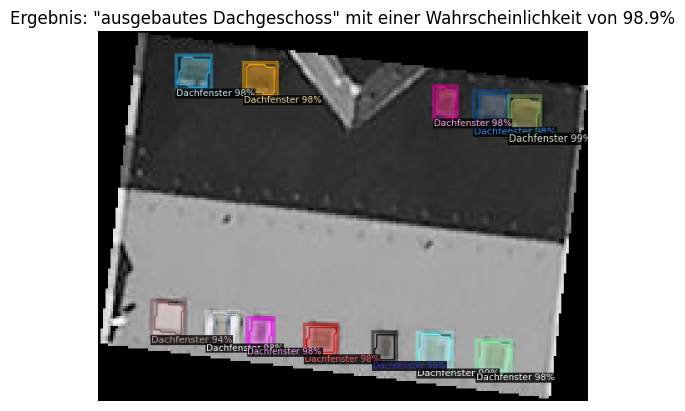

Yes difference
difference_counter = 1 at image 2


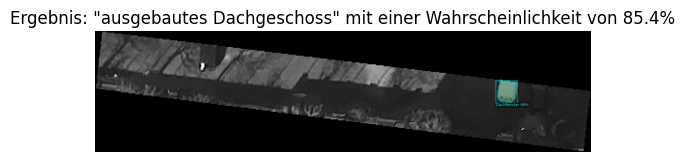

No difference


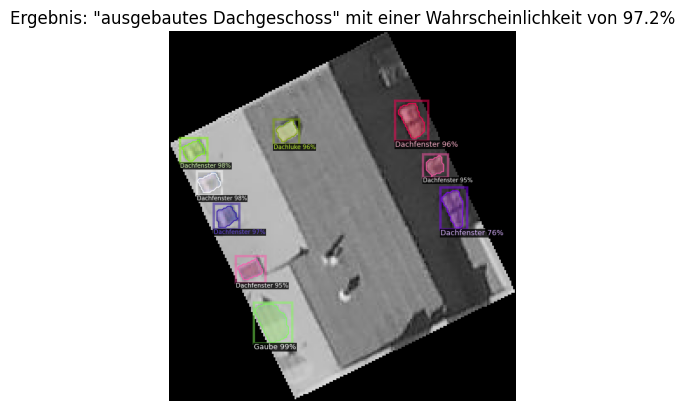

No difference


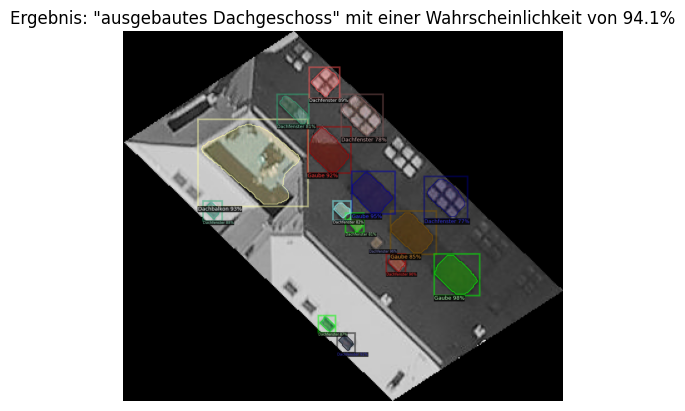

No difference


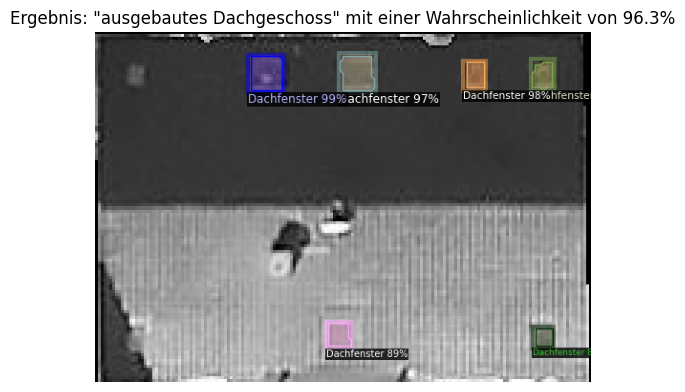

No difference


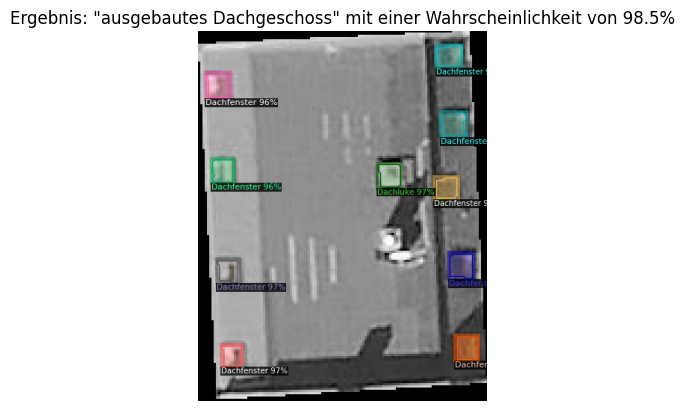

No difference


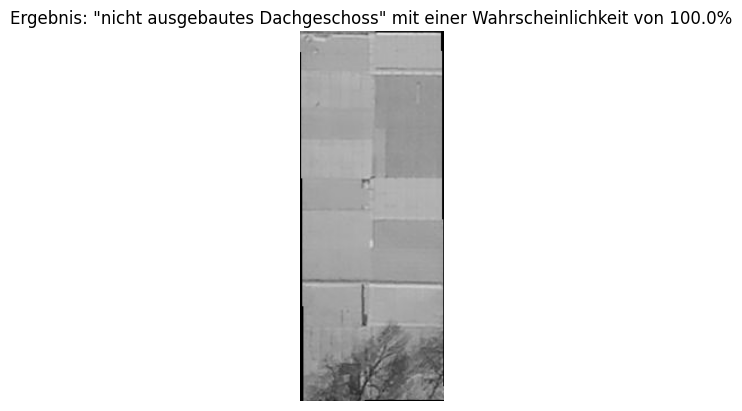

No difference


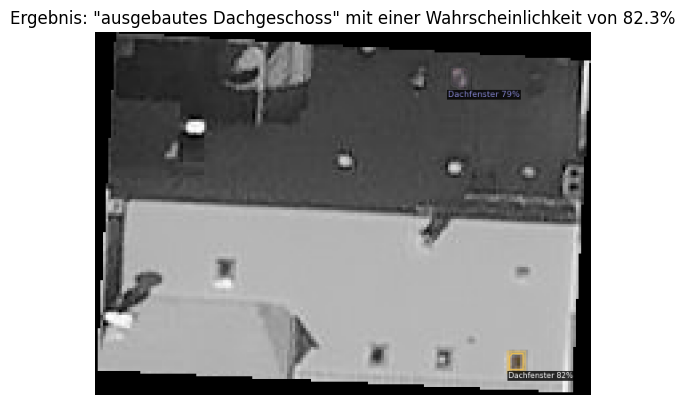

No difference


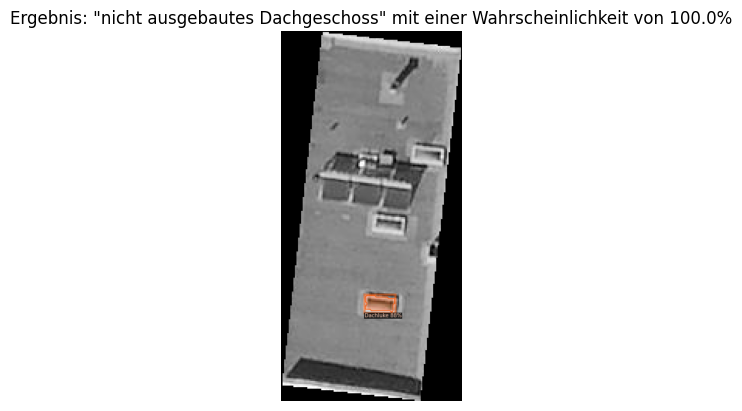

No difference


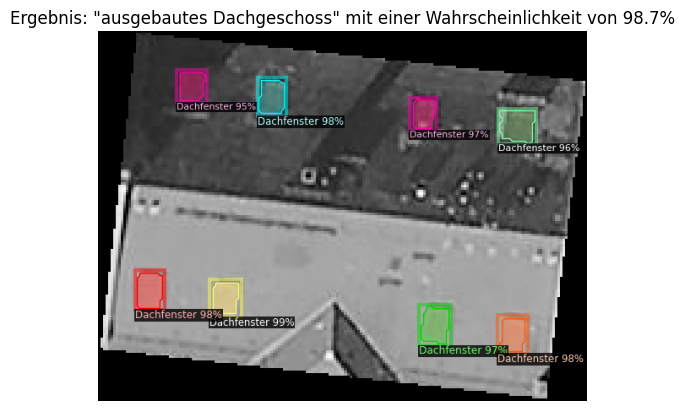

No difference


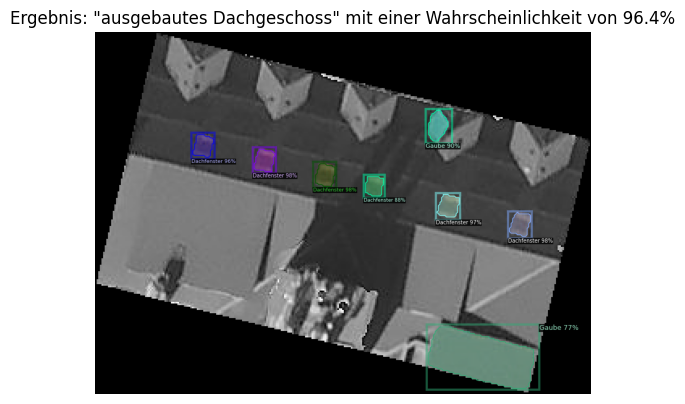

No difference


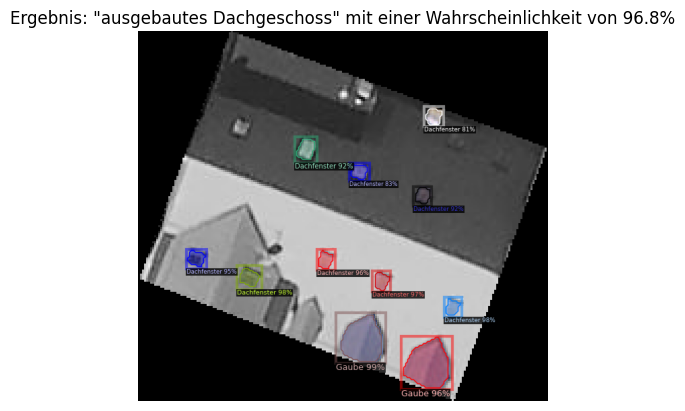

No difference


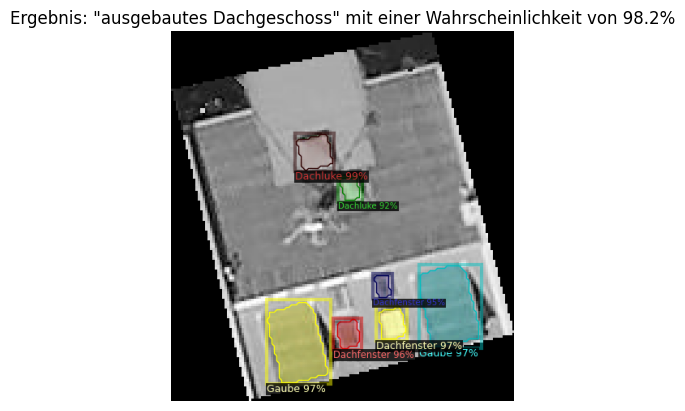

No difference


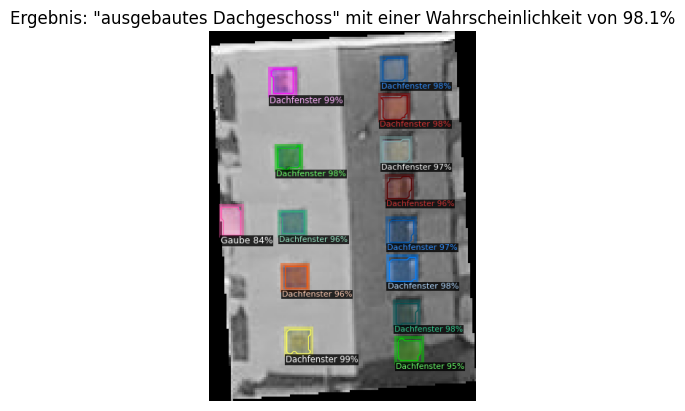

No difference


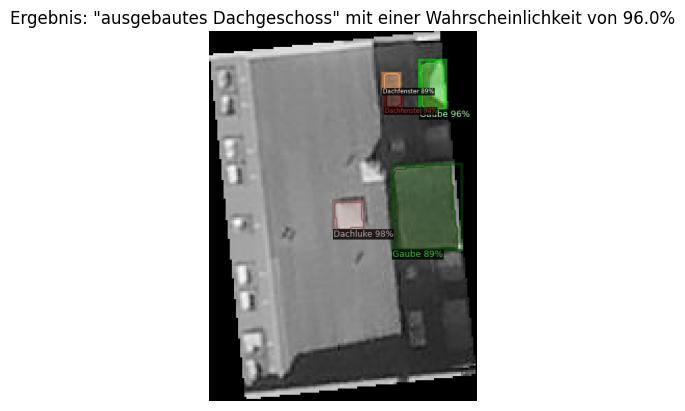

No difference


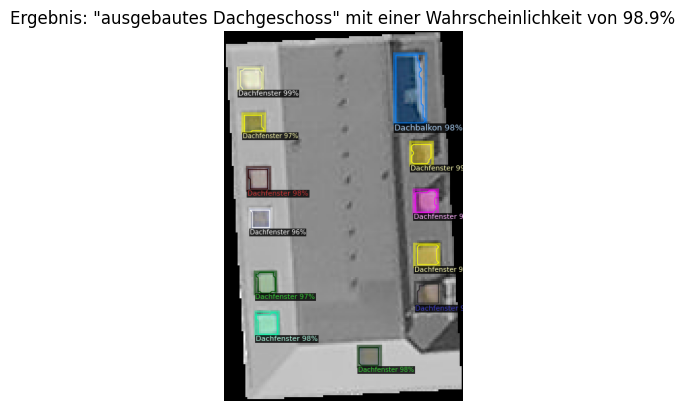

No difference


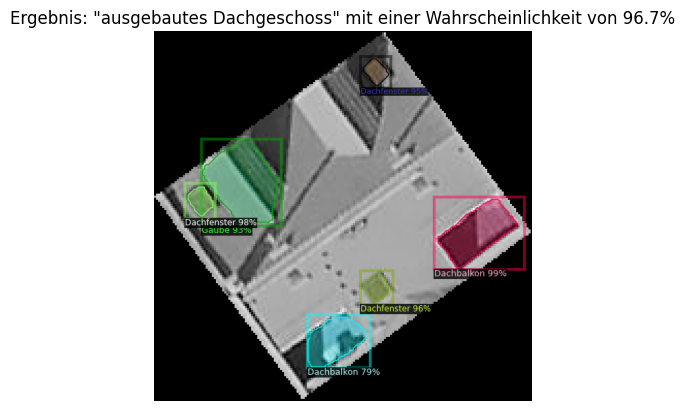

No difference


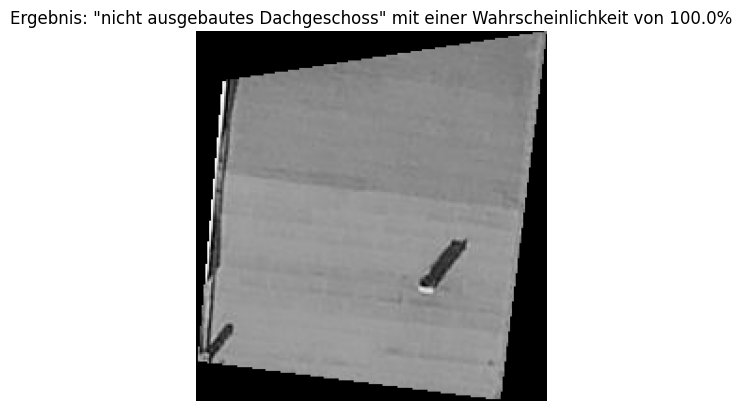

No difference


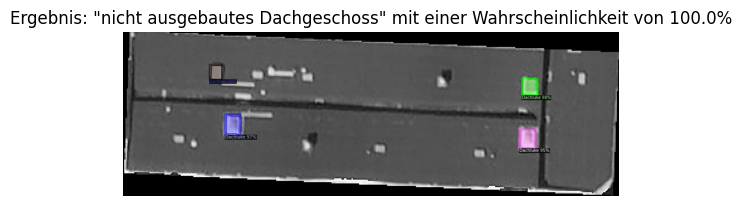

No difference


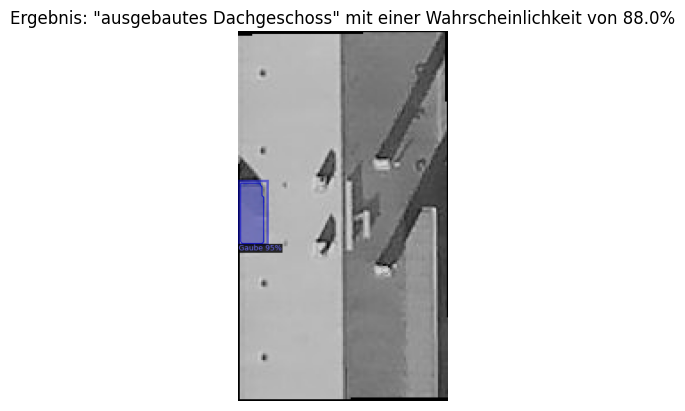

No difference


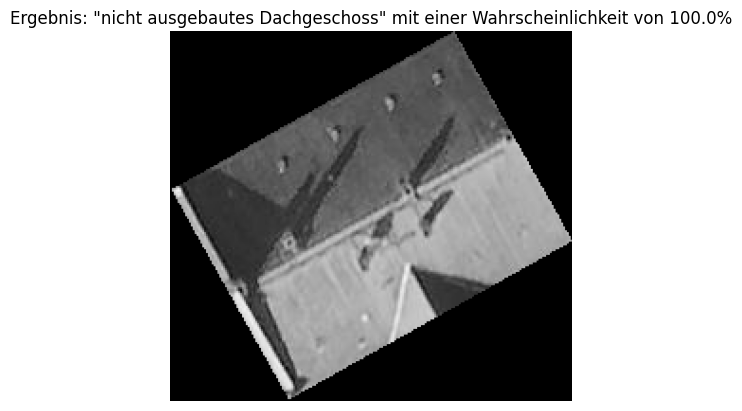

No difference


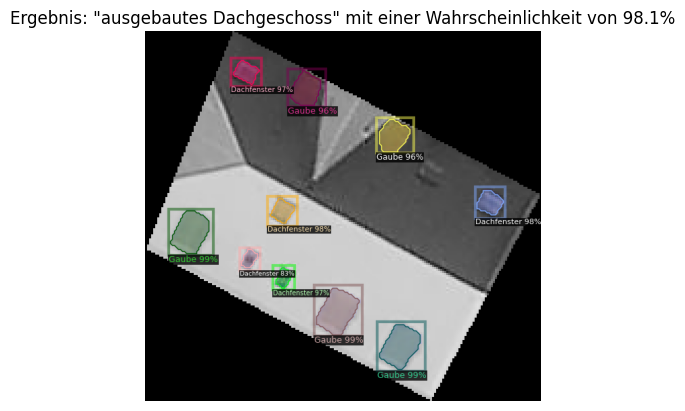

No difference


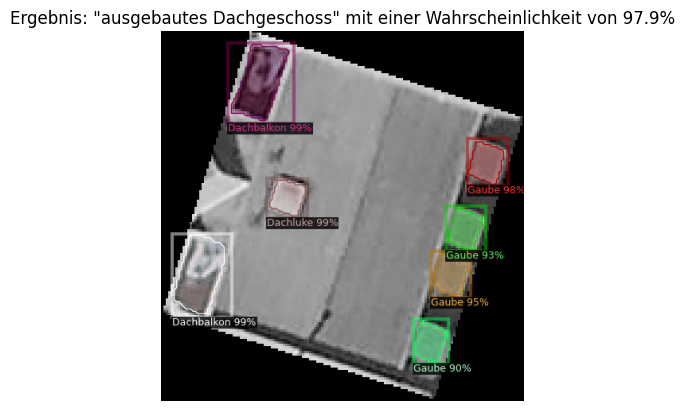

No difference


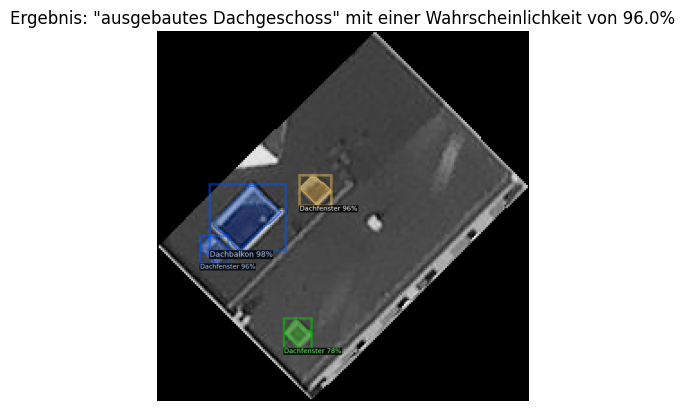

No difference


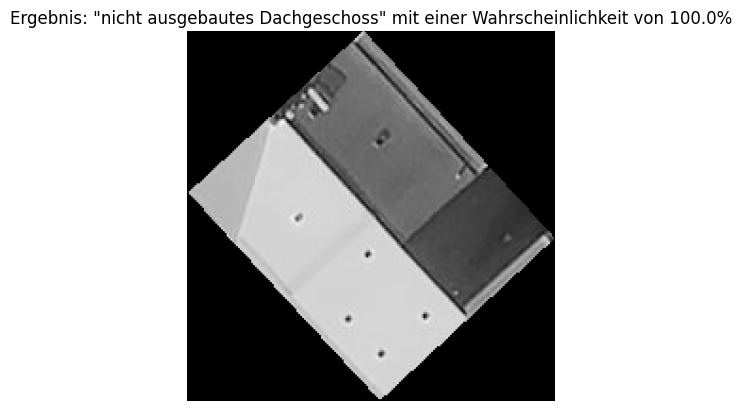

No difference


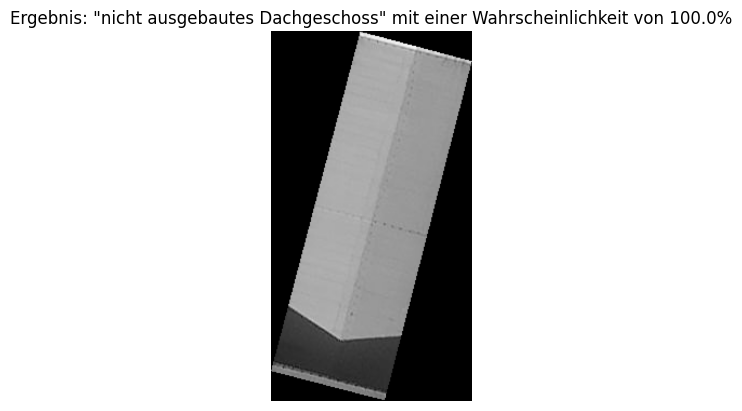

No difference


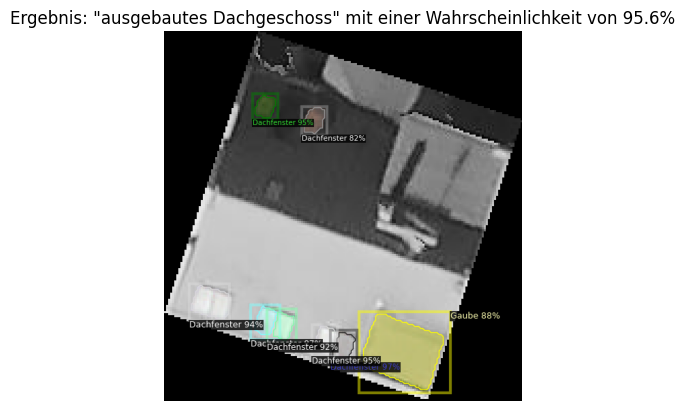

No difference


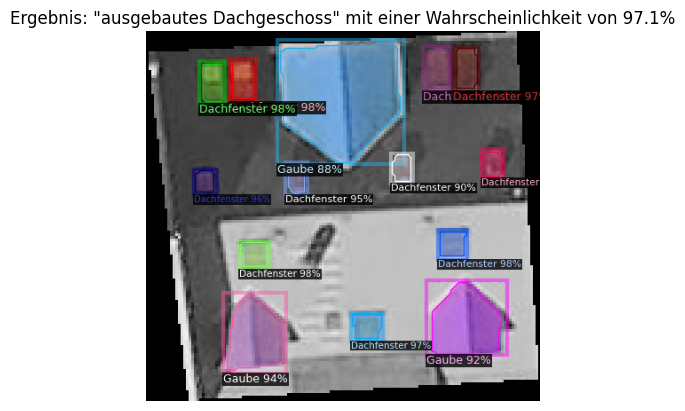

No difference


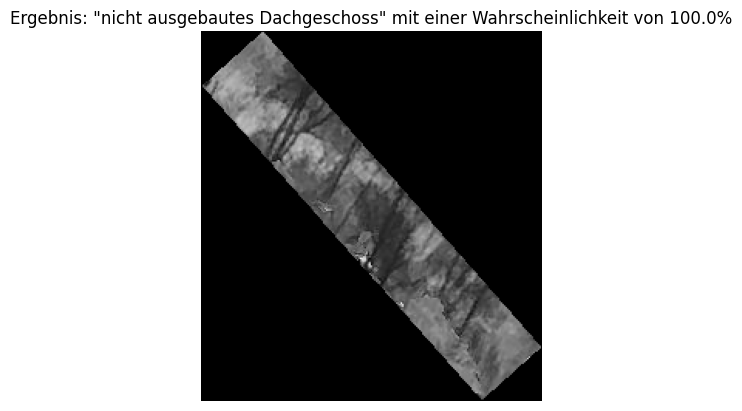

No difference


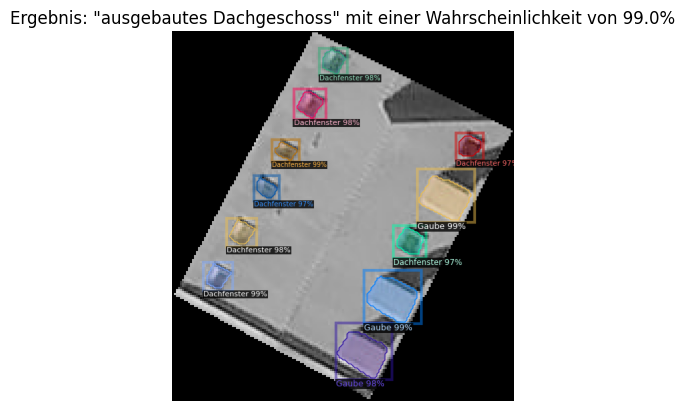

No difference


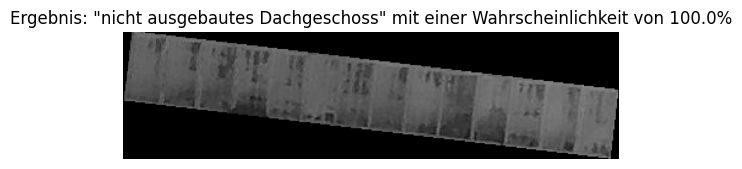

No difference


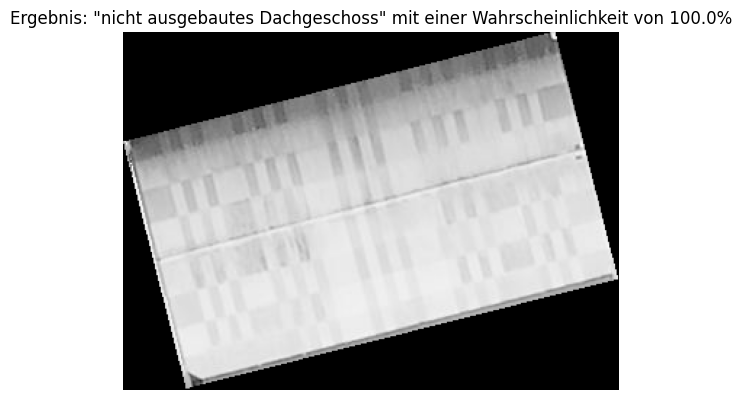

No difference


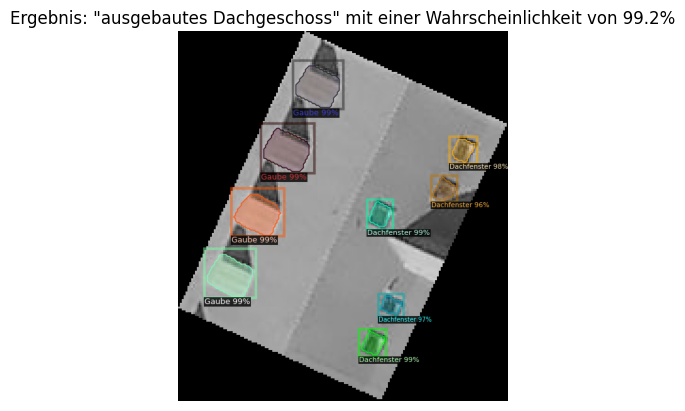

No difference


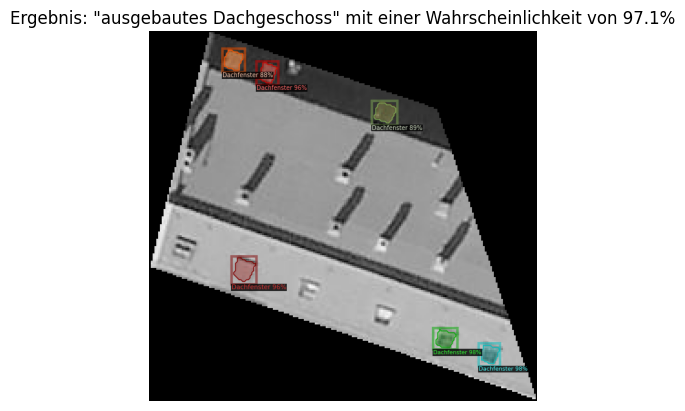

No difference


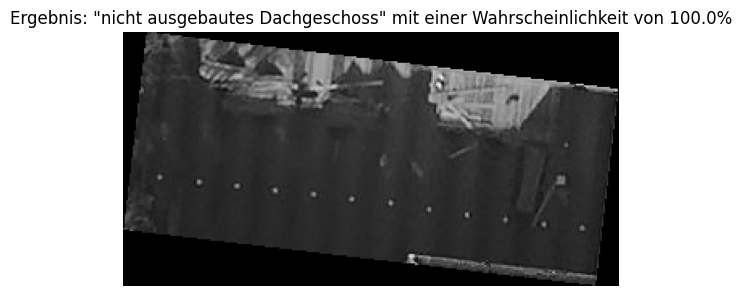

No difference


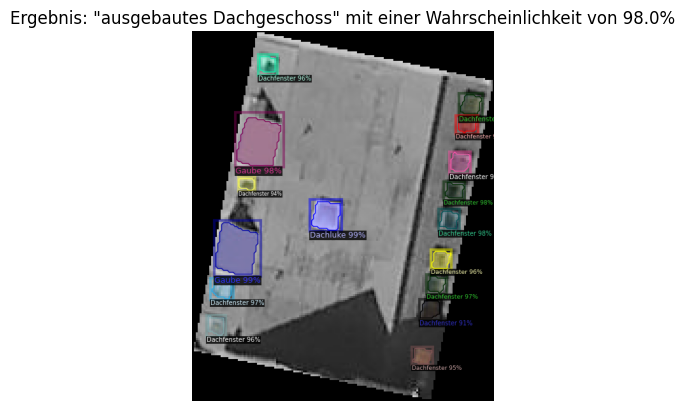

No difference


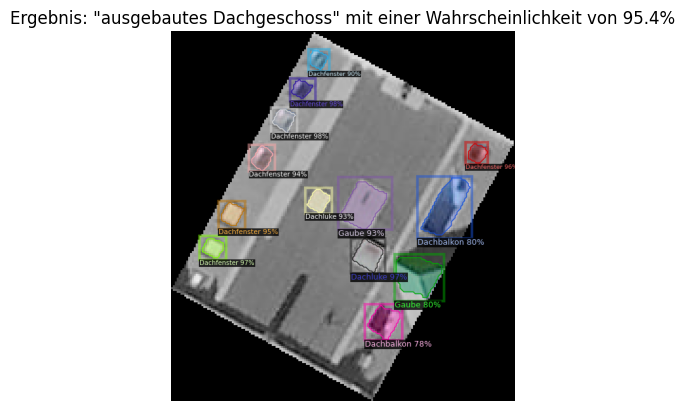

No difference


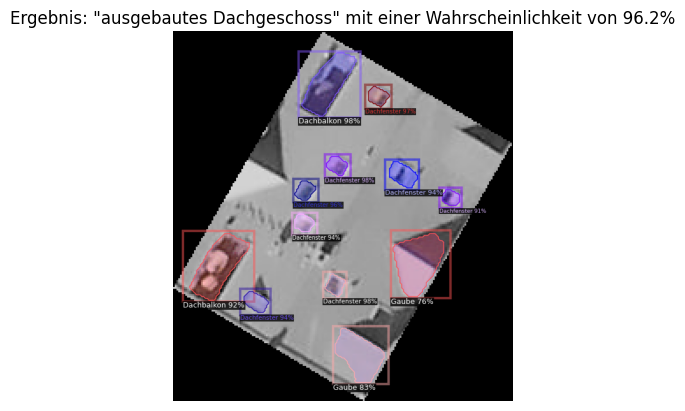

No difference


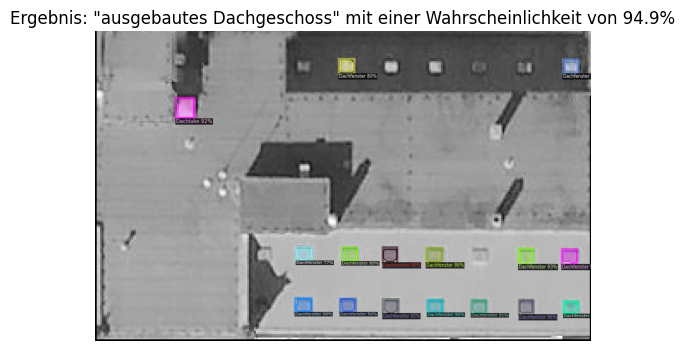

No difference


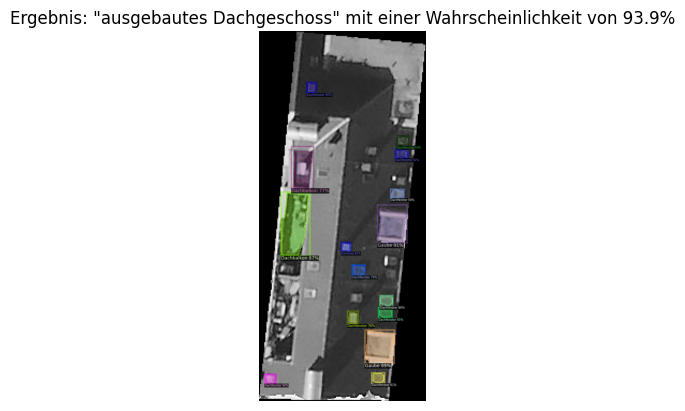

No difference


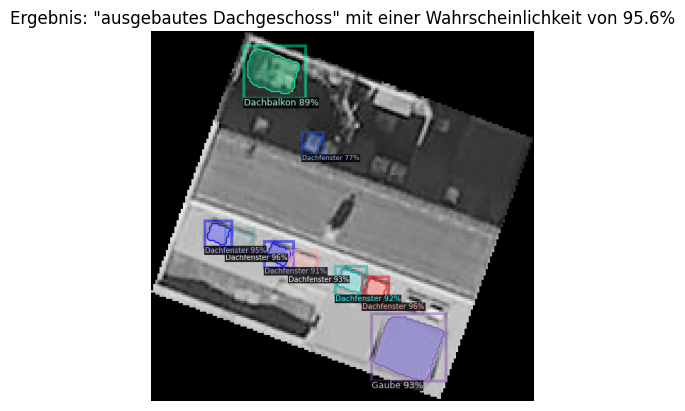

No difference


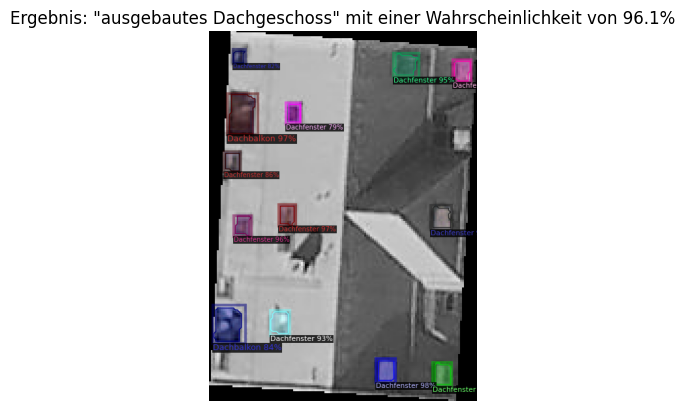

No difference


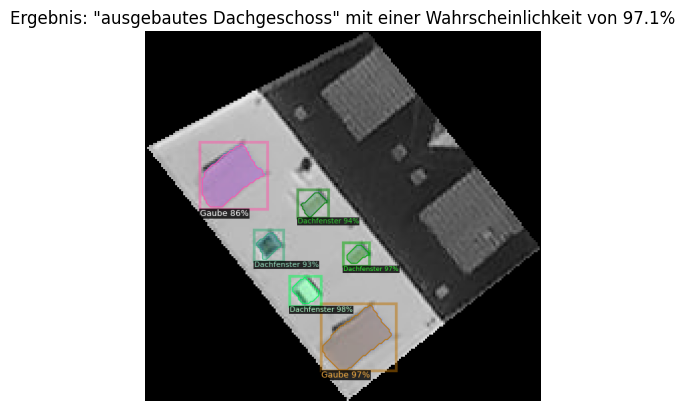

No difference


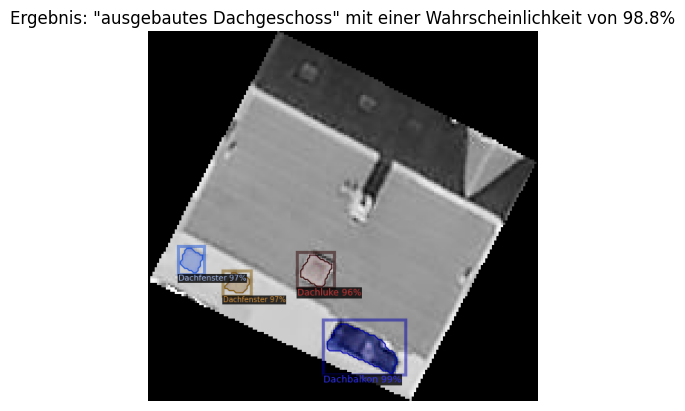

Yes difference
difference_counter = 2 at image 45


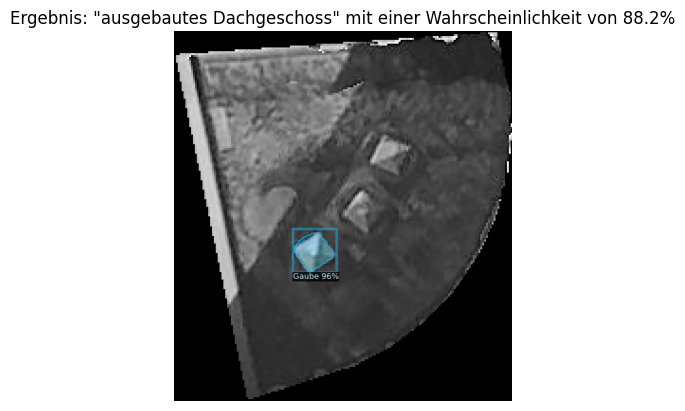

No difference


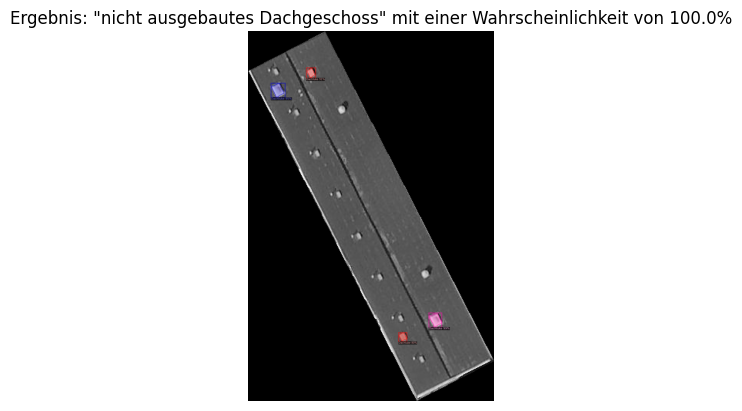

No difference


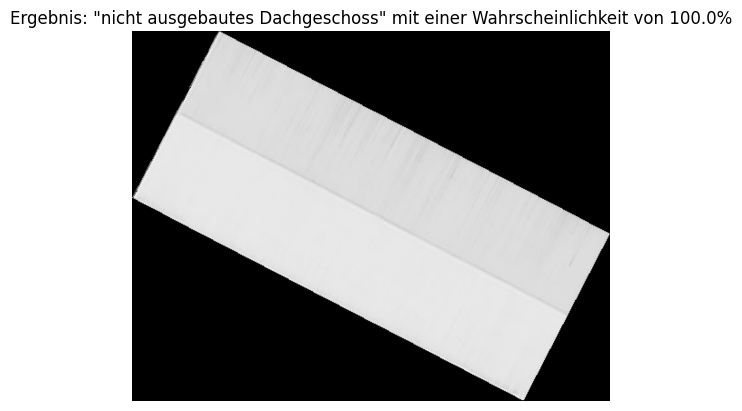

No difference


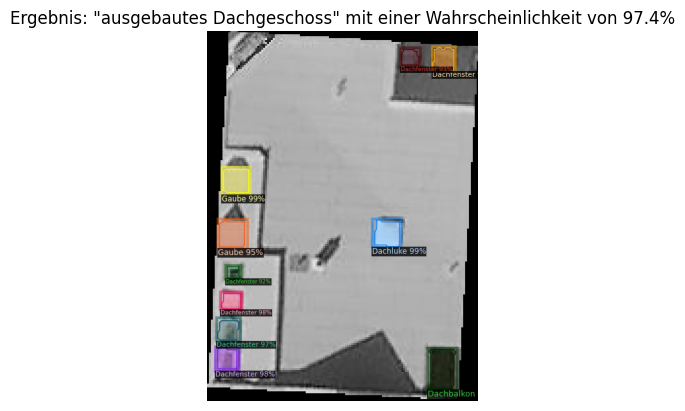

No difference


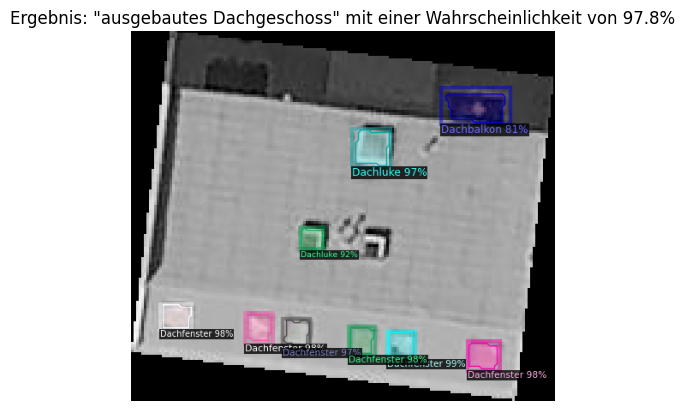

No difference


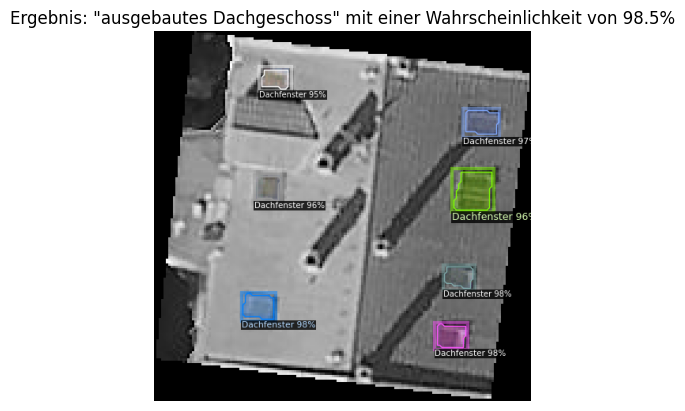

No difference


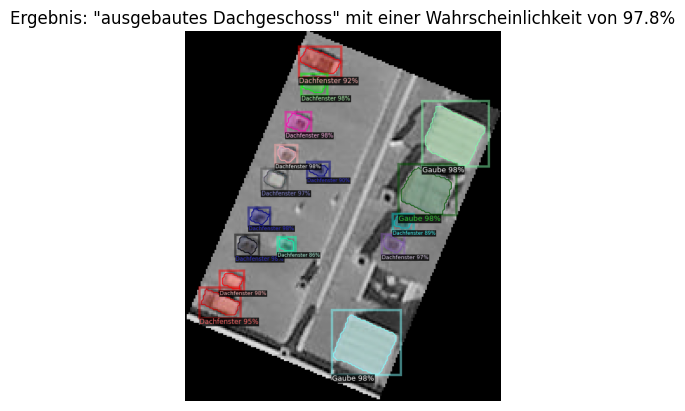

No difference


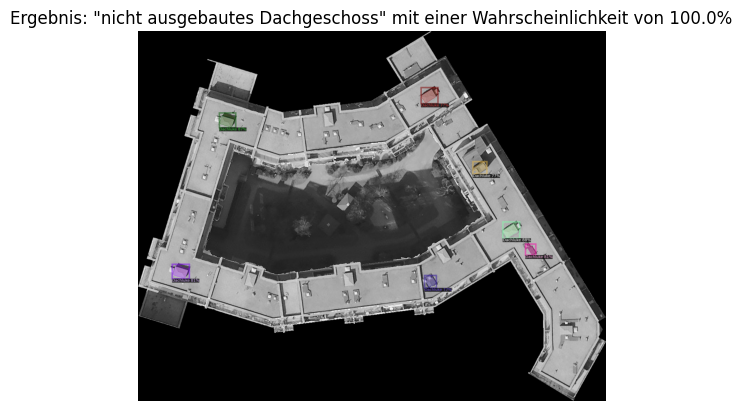

Yes difference
difference_counter = 3 at image 53


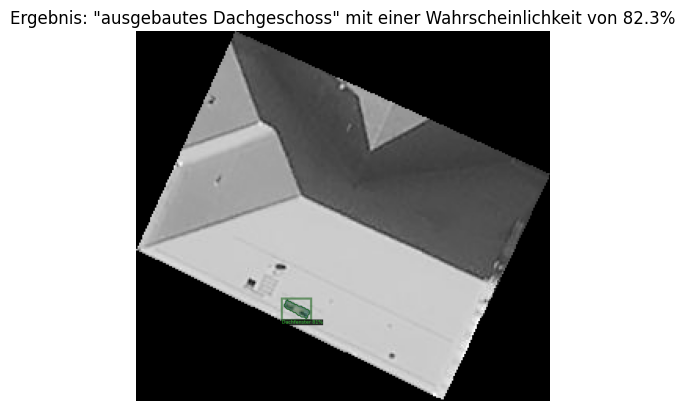

No difference


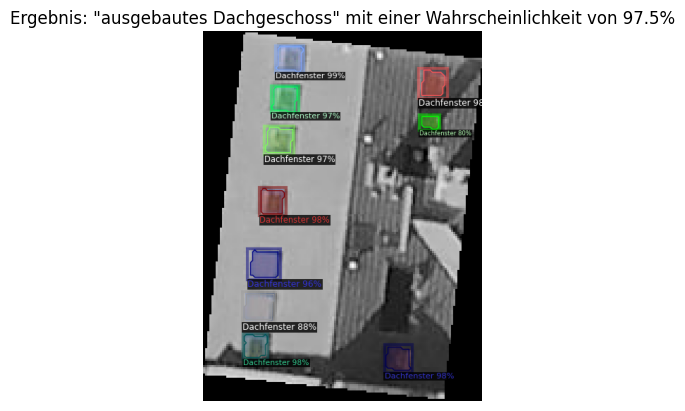

Yes difference
difference_counter = 4 at image 55


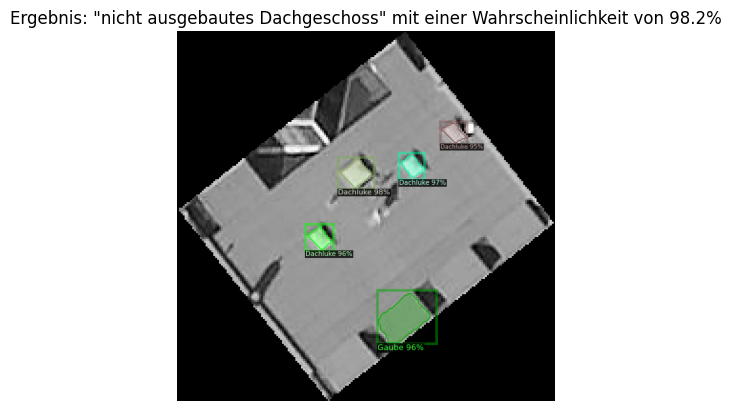

No difference


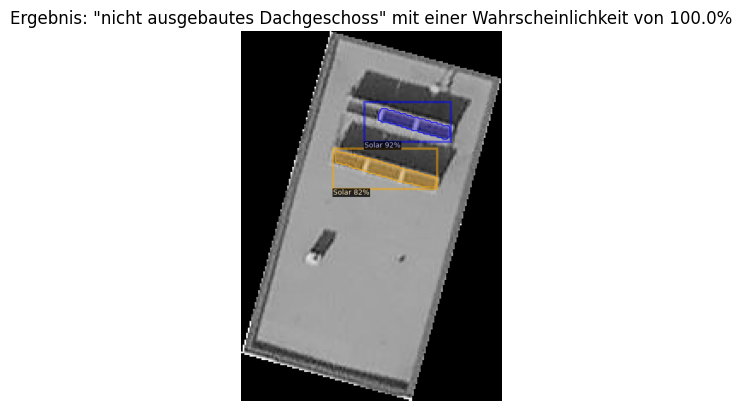

Yes difference
difference_counter = 5 at image 57


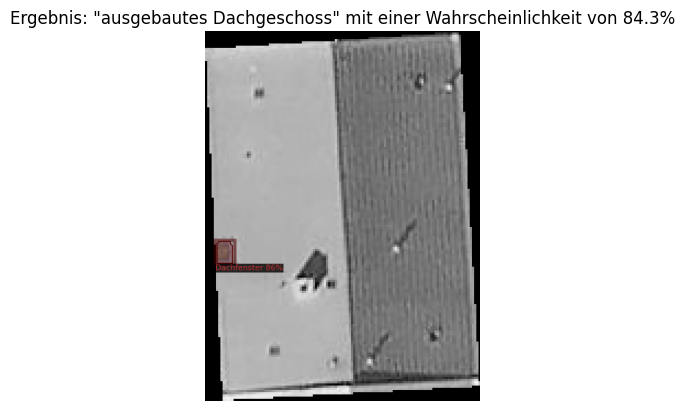

No difference


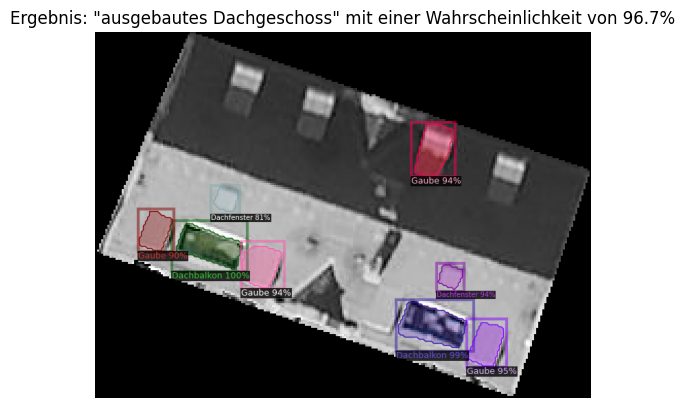

No difference


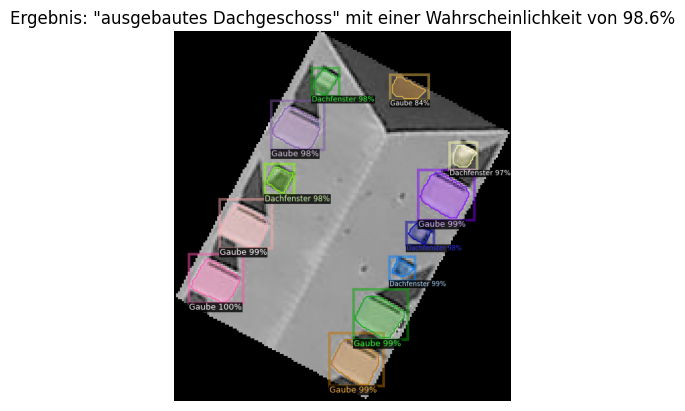

No difference


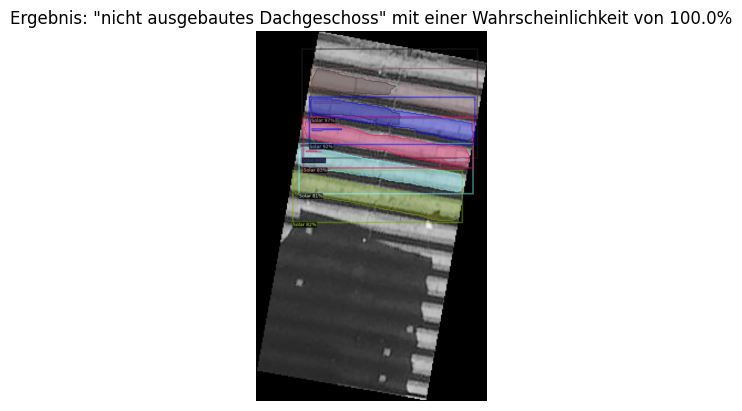

No difference


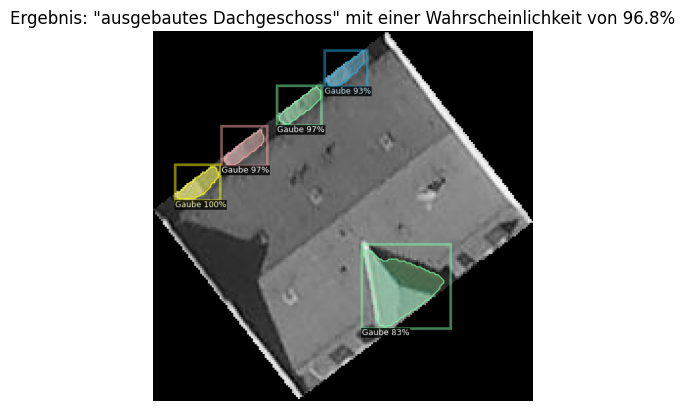

No difference


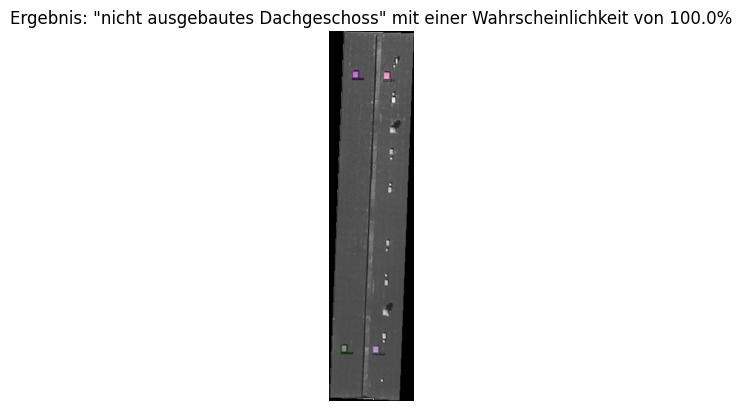

No difference


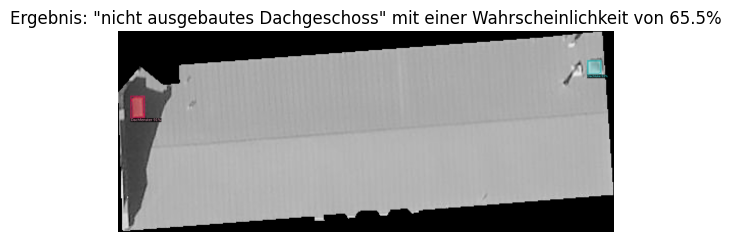

No difference


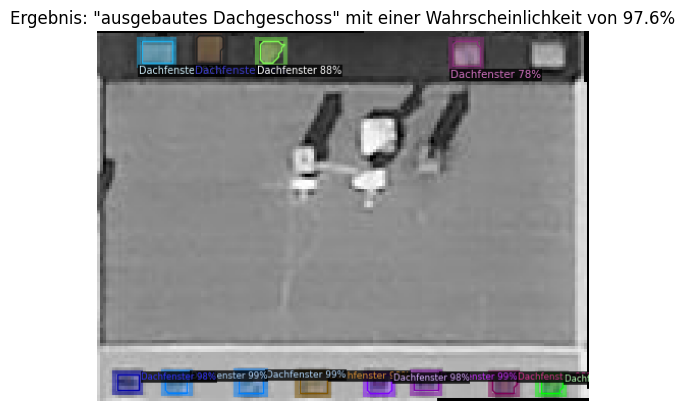

No difference


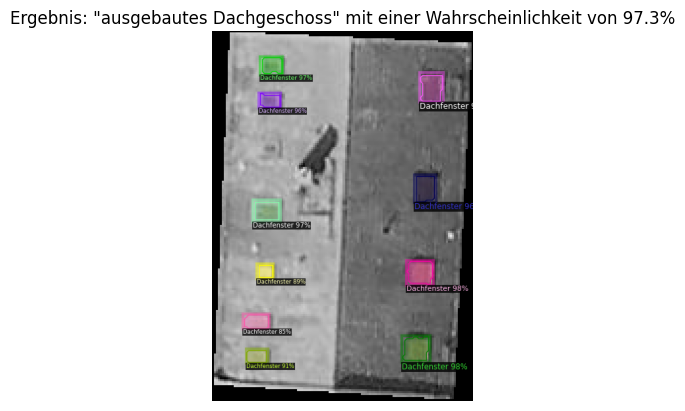

No difference


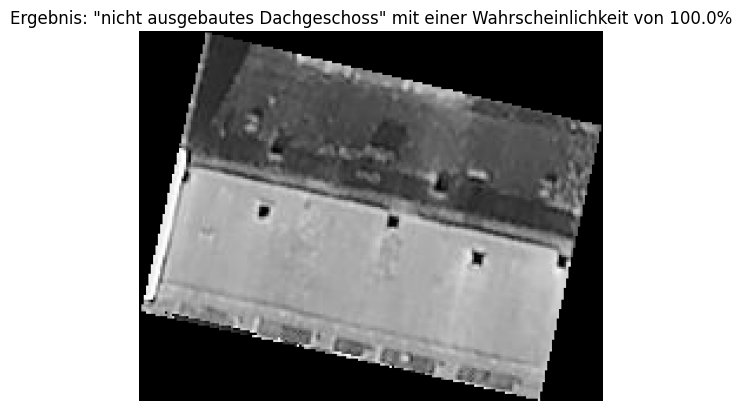

No difference


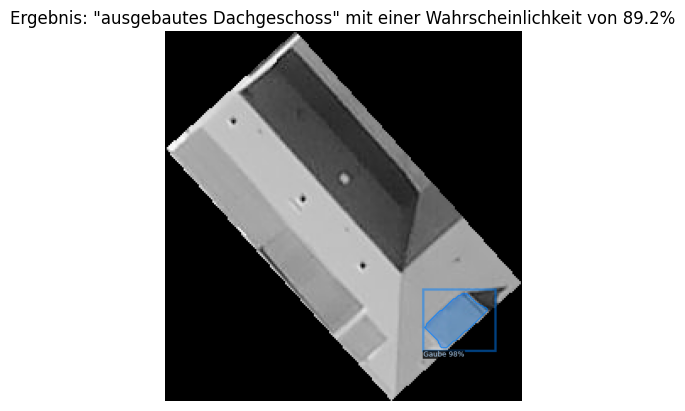

Yes difference
difference_counter = 6 at image 68


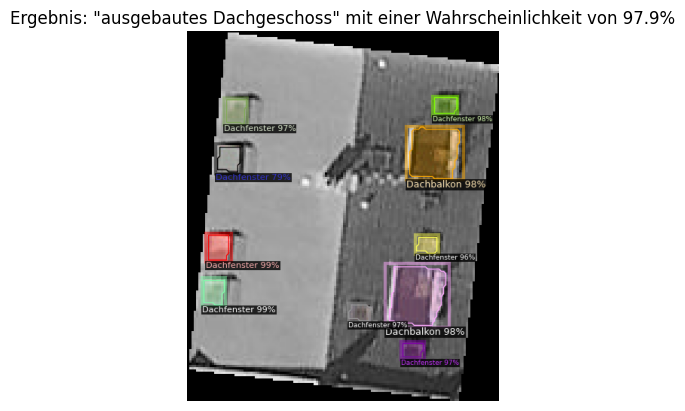

No difference


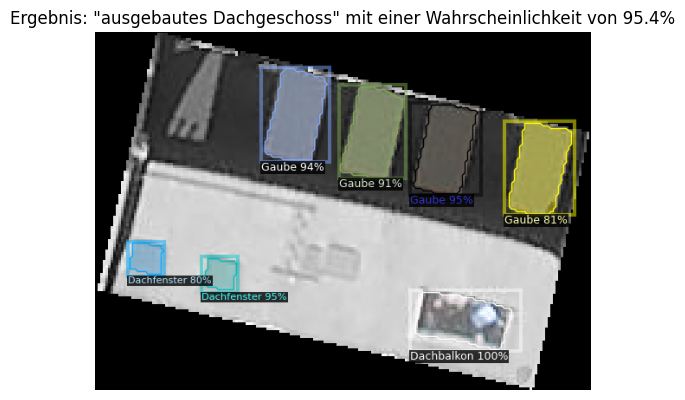

No difference


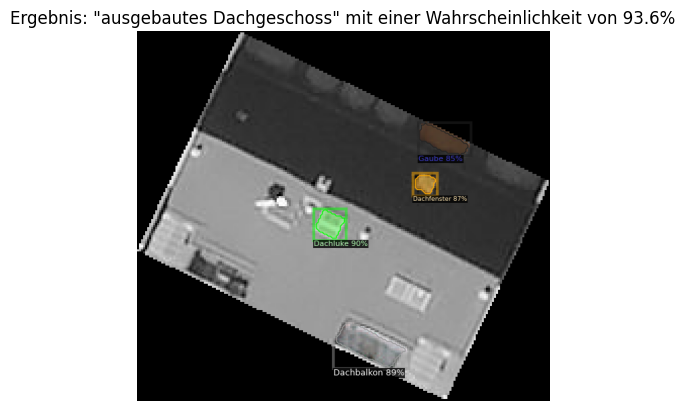

No difference


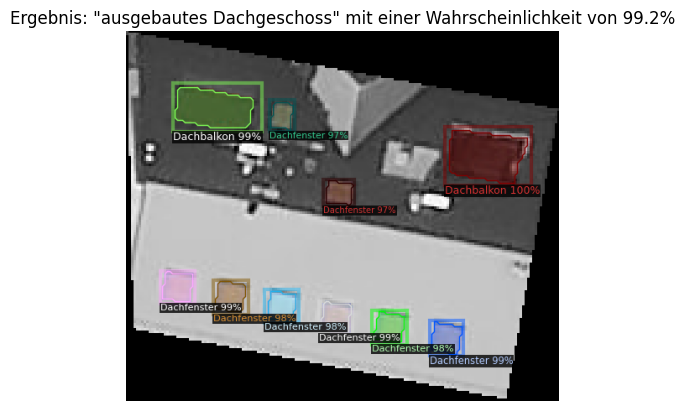

No difference


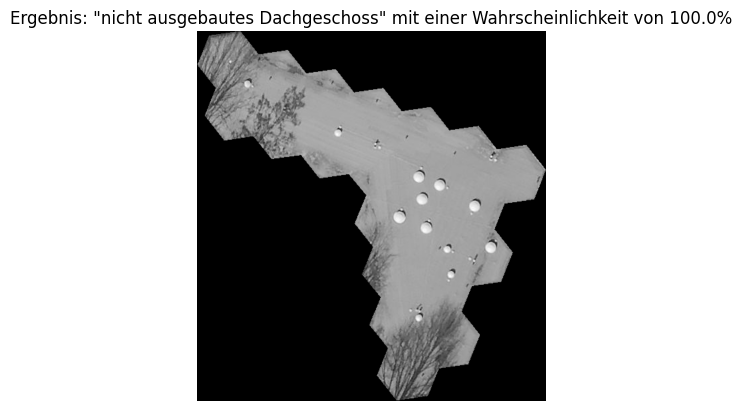

No difference


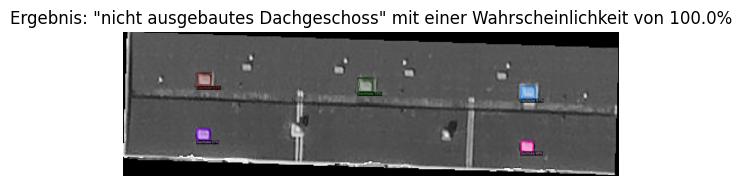

No difference


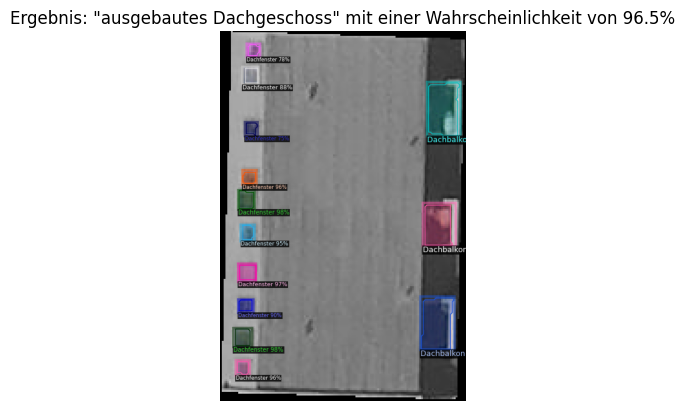

No difference


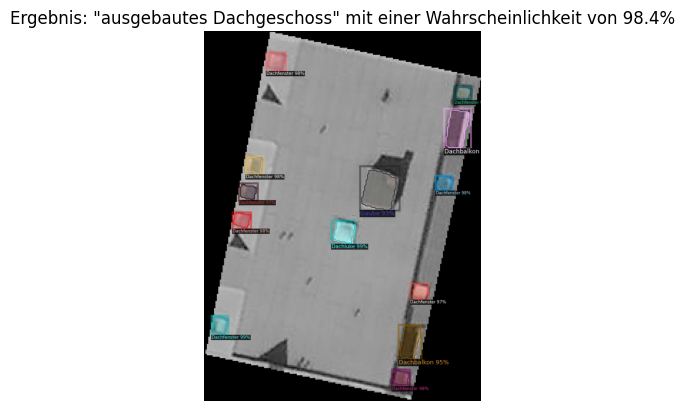

Yes difference
difference_counter = 7 at image 76


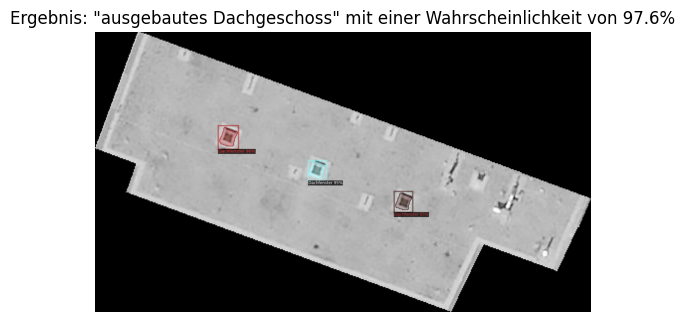

76
7
accuracy: 90.8


In [18]:
#"""
#not needed if check_roof_classification_with_json() is not called (in producive environment)
difference_counter = 0
#"""

# Perform predictions on each image in the folder
for index, image_file in enumerate(image_files):
    # Load and preprocess the image
    image_path = os.path.join(image_folder, image_file)
    image = cv2.imread(image_path)
    #image.shape #Height,Width,Channel 3 channels -> farb RGB, BGR

    #######################################
    # Perform prediction on the image
    output = predictor(image)
    #print(output) #pred_classes id's 
    
    #######################################
    # create list of the predicted instances
    ouptut_instances_list = create_instances_list(output)

    #print(ouptut_instances_list)
    #print(len(ouptut_instances_list))
    
    #######################################
    # do classification whether "ausgebautes Dachgeschoss" or "nicht ausgebautes Dachgeschoss"
    classification, classification_score = classify_roof(ouptut_instances_list)
    heading = f'Ergebnis: "{classification}" mit einer Wahrscheinlichkeit von {round(classification_score*100, 1)}%'

    #######################################
    #"""
    # not needed in productive environment
    # check whether classification is differnt from annotation in validation dataset
    # just makes sense if the image_folder and json_test_path belong to the same dataset
    difference = check_roof_classification_with_json(classification, image_file, json_data) 
    print(difference)
    if difference == 'Yes difference':
        difference_counter = difference_counter + 1
        print(f"difference_counter = {difference_counter} at image {index + 1}")
        #visualize_predictions(image, roof_metadata, output, heading)
    #"""
    
    #######################################
    # Visualize and display the output
    visualize_predictions(image, roof_metadata, output, heading)

#"""
#not needed in productive environment
print(len(image_files))
print(difference_counter)
accuracy = round((1 - (difference_counter / len(image_files)))*100, 1)
print(f"accuracy: {accuracy}")
#"""
